In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

#join 메서드를 사용하여 _housing/data에 train, test.csv파일을 넣음
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
#data가 너무 길기 때문에 월까지 표기할 필요성이 생김
#astype는 데이터프레임의 자료형을 바꿀 때 사용
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
#타겟데이터에 해당하는 price를 y에 저장 후 train에서 삭제(라벨제거과정)
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
#id제거로 트레인데이터 전처리 종료 = id는 0에서부터 나열된 숫자이므로 학습에 필요없음
del train['id']
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
#테스트 데이터에서도 date전처리 및 아이디 제거, orice는 타겟 값이 원래 존재하지 않음
test['date'] = test['date'].apply(lambda i:i[:6]).astype(int)
del test['id']
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
print(y)

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64


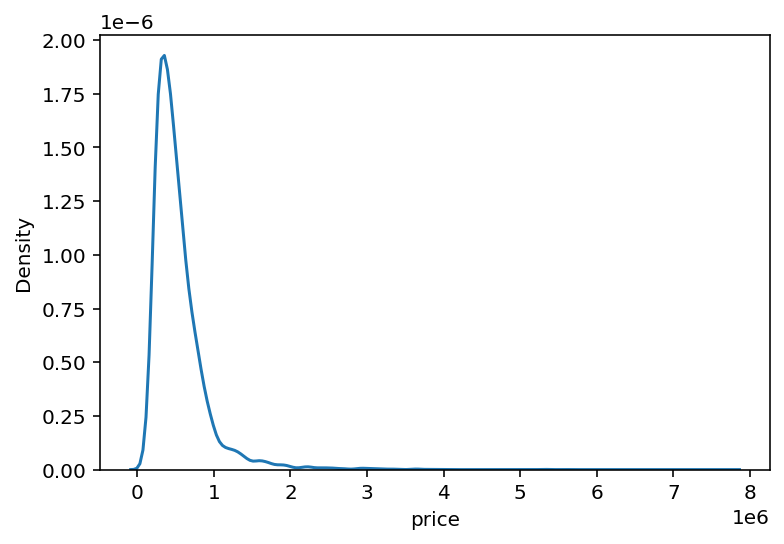

In [9]:
#kee = kernel density estimation// 확률 밀도 추정 시 사용
sns.kdeplot(y)
plt.show()

In [10]:
#그래프에서 지나치게 0~1에 분포해있는 것을 해소하기 위해 log변환 필요
#np.log1p()를 사용하여 밀집 데이터를 해소해주고 모델이 값을 예측한 후에 np.expm1()을 사용하여 원래대로 되돌림
y=np.log1p(y)
print(y)

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64


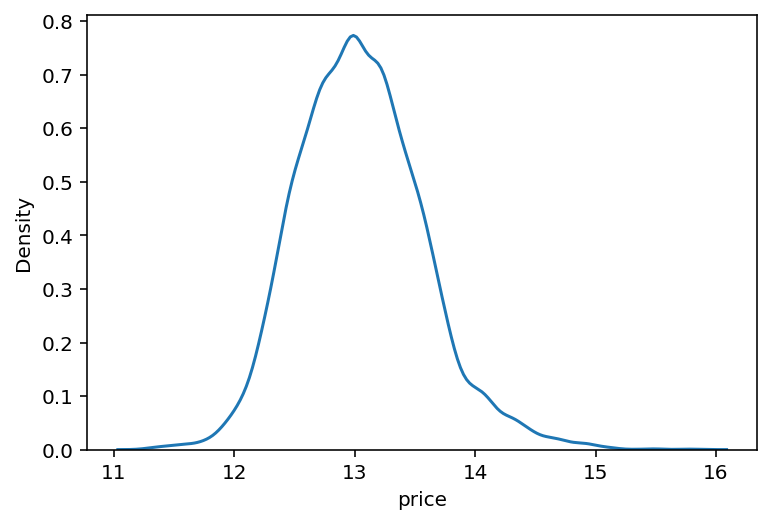

In [11]:
#log1p를 사용하여 밀집도 해소에 성공
sns.kdeplot(y)
plt.show()

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [13]:
#rmse점수를 계산하기 위해 mean_squared_error모듈을 가져옴
#rmse = 모델이 예측한 값과 실제 환경에서 관찰되는 값의 차이를 다룰 때 사용
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [14]:
#rmse는 mse에 제곱근을 씌운 것
#계산을 완료한 이후이므로 expm1()을 사용하여 price를 원래대로 되돌림
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [15]:
#모델 가져오기
#xgboost = 분류, 회귀 모두 지원. 여러개의 의사결정나무를 조합해서 사용하는 앙상블알고리즘
#lightgbm = xgboost에 비해 예측성능 차이가 크지 않음. 학습시간이 더 짧은 것이 특징. 리프 중심 트리 분할 방식 사용(= 비대칭)// max_depth에 대한 파라미터 설정이 중요
#GradientBoostingRegressor=gboost = 앙상블 이전까지 오차보정을 위해 예측기를 순차적으로 추가하지만, 잔여오차를 새로운 예측기에 학습시킴
#RandomForestRegressor= 랜덤포레스트 = 과적합 조절, 예측의 정확도를 잡기위해 평균을 사용

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [16]:
random_state=2020  #랜덤이 고정값을 가짐

#모델명 간략화
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [17]:
#__class__는 현재 클래스를 나타낼 때 사용// __name__은 해당 모듈의 위치를 알려줌
gboost.__class__.__name__

'GradientBoostingRegressor'

In [18]:
#모델별 학습예측함수
def get_scores(models, train, y):
    df = {}
    
    #모델s=리스트를 model에 넣음
    for model in models:
        
        #모델 이름 얻기
        model_name = model.__class__.__name__
        
        #트레인, 테스트 데이터셋 분리
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        
        #학습
        model.fit(X_train, y_train)
        
        #예측
        y_pred = model.predict(X_test)
        
        #예측결과 rmse값 저장 => 위에서 rmse()를 정의해둠
        df[model_name] = rmse(y_test, y_pred)
        
        #dataframe에 저장// df.T= 데이터프레임의 행, 열 교환//sort_values=축 정렬
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [19]:
#하이퍼파라미터 조절
#그리드탐색 = 하이퍼 파라미터의 값들을 정해두고 그 값으로 만들어질 모든 조합을 탐색
from sklearn.model_selection import GridSearchCV

In [20]:
#xgboost 하이퍼 파라미터 수치
#n_estimators : 실험의 수를 몇 개로 할 것인지
#max_depth : 실험에 대한 깊이. xgboost에서는 트리의 깊이로 표현 보통 3-10을 사용

param_grid = {
    'n_estimators' :[30,330],
    'max_depth' : [4,38],
}

In [21]:
#lightgbm사용
model = LGBMRegressor(random_state=random_state)

In [22]:
#param_grid :탐색할 파라미터의 종류/ scoring : 점수평가지표
#cv : 교차검증을 수행하기위해 트레인셋을 나누는 조각 수
#verbose : 그리드 탐색 진행과정을 출력해서 보여줄 메시지 수
#n_jobs : 그리드 탐색을 진행하면서 사용할 cpu 수

grid_model = GridSearchCV(model, param_grid=param_grid, \
                         scoring = 'neg_mean_squared_error', \
                         cv = 7 , verbose=1, n_jobs=5)
grid_model.fit(train,y)

Fitting 7 folds for each of 4 candidates, totalling 28 fits


GridSearchCV(cv=7, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [4, 38], 'n_estimators': [30, 330]},
             scoring='neg_mean_squared_error', verbose=1)

######  param_grid에 n_estimators, max_depth 2개씩 * 교차검증의 수를 7번  =  28

In [23]:
grid_model.cv_results_

{'mean_fit_time': array([0.21793124, 1.12895427, 0.2463572 , 1.51886722]),
 'std_fit_time': array([0.07274359, 0.23963136, 0.01548181, 0.52261542]),
 'mean_score_time': array([0.01265495, 0.06578146, 0.02042362, 0.06106033]),
 'std_score_time': array([0.00785006, 0.01389971, 0.01045708, 0.01637091]),
 'param_max_depth': masked_array(data=[4, 4, 38, 38],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[30, 330, 30, 330],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 4, 'n_estimators': 30},
  {'max_depth': 4, 'n_estimators': 330},
  {'max_depth': 38, 'n_estimators': 30},
  {'max_depth': 38, 'n_estimators': 330}],
 'split0_test_score': array([-0.03770567, -0.02503365, -0.03205518, -0.02489949]),
 'split1_test_score': array([-0.04310643, -0.02946643, -0.03684281, -0.02852724]),
 'split2_test_score': array([-0.04074481

In [24]:
#params와 mean_test_score만 가져오기
params = grid_model.cv_results_['params']
params

[{'max_depth': 4, 'n_estimators': 30},
 {'max_depth': 4, 'n_estimators': 330},
 {'max_depth': 38, 'n_estimators': 30},
 {'max_depth': 38, 'n_estimators': 330}]

In [25]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.04031936, -0.02660762, -0.03387006, -0.02618662])

In [26]:
#params, mean_test_score를 데이터프레임으로 출력
results = pd.DataFrame(params)
results['score']=score

results

,max_depth,n_estimators,score
0,4,30,-0.040319
1,4,330,-0.026608
2,38,30,-0.033870
3,38,330,-0.026187


In [27]:
#스코어 값을 양수로 바꾸기위해 -1을 곱하고 제곱근을 씌워준다
#neg_mean_squared_error=> mse는 비용함수이므로 효용함수로 바꾸기 위해 음수값을 붙임
#비용함수 = 예측값과 실제값의 차이 = 원래의 값과 가장 오차가 작은 함수를 도출하기위함
#효용함수 = 머신러닝 모델의 성능이 얼마나 우수한지 측정하는 것

results['RMSE'] = np.sqrt(-1 *results['score'])
results

,max_depth,n_estimators,score,RMSE
0,4,30,-0.040319,0.200797
1,4,330,-0.026608,0.163118
2,38,30,-0.033870,0.184038
3,38,330,-0.026187,0.161823


In [28]:
#rmse함수에서 np.expm1함수를 사용하여 원래대로 price를 복원한 후 rmse값을 계산함
#반면 그리드탐색을 하면서 np.expm1()으로 변환하는 과정이 없었기 때문에 log변환된 price데이터에서 손실함수값을 구함
#따라서 rmse가 아닌 rmsle(root mean squared log error)로 수정해야함

results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,4,30,-0.040319,0.200797
1,4,330,-0.026608,0.163118
2,38,30,-0.033870,0.184038
3,38,330,-0.026187,0.161823


#### 분명 위에서 expm1함수를 사용한 것을 봤는데, 사용하지 않았다는 것을 보고 오타가 났나 싶었다. 하지만 착각이었고,  실제로 그리드탐색을 하면서부터는 변형이 되어있지 않았다.

In [29]:
#rmsle가 낮은 순으로 배열
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,38,330,-0.026187,0.161823
1,4,330,-0.026608,0.163118
2,38,30,-0.033870,0.184038
0,4,30,-0.040319,0.200797


In [30]:
#위의 값을 아래와 같은 함수로 만들 수 있다
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [31]:
#위의 함수로 그리드탐색 진행 + 가장 좋은 조합 확인
param_grid={
    'n_estimators': [30,330],
    'max_depth' : [4,38],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,38,330,-0.026124,0.161628
1,4,330,-0.026809,0.163734
2,38,30,-0.033890,0.184092
0,4,30,-0.040613,0.201526


In [32]:
#위에서의 최상의 값은 depth38, estimators 330 // 따라서 아래값에 38과 330대입
model = LGBMRegressor(max_depth=38, n_estimators=330, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.12996236, 13.10304005, 14.15457773, ..., 13.05267977,
       12.66797559, 13.01746877])

In [33]:
#변수명만 바꿔준 price를 np.expm1을 사용하여 원래스케일로 돌려두기
prediction = np.expm1(prediction)
prediction

array([ 503812.96299047,  490430.0837884 , 1403636.63142576, ...,
        466343.43306613,  317417.25233502,  450208.7088241 ])

In [34]:
#sample_submission.csv를 가져옴
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [35]:
#예측한 값을 집어넣음
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.038130e+05
1,15036,4.904301e+05
2,15037,1.403637e+06
3,15038,3.074702e+05
4,15039,3.281770e+05


In [36]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [37]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    
    #train, y로 훈련
    model.fit(train, y)
    
    #예측
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    #경로설정
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    
    #파일 가져오기 및 저장
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [38]:
#모델 학습 후 저장가능
#save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

[CV] END .......................max_depth=4, n_estimators=30; total time=   0.2s
[CV] END ......................max_depth=4, n_estimators=330; total time=   1.0s
[CV] END ......................max_depth=38, n_estimators=30; total time=   0.2s
[CV] END ......................max_depth=38, n_estimators=30; total time=   0.3s
[CV] END .......................max_depth=4, n_estimators=30; total time=   0.2s
[CV] END ......................max_depth=4, n_estimators=330; total time=   1.0s
[CV] END ......................max_depth=38, n_estimators=30; total time=   0.5s
[CV] END ......................max_depth=38, n_estimators=30; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=30; total time=   0.2s
[CV] END ......................max_depth=4, n_estimators=330; total time=   1.0s
[CV] END ......................max_depth=38, n_estimators=30; total time=   0.3s
[CV] END .....................max_depth=38, n_estimators=330; total time=   1.2s
[CV] END ...................

# 1차시도 113634.92767
# 2차시도 110586.43041
# 3차시도 107674.55705(최종)[30,330][4,38]

하이퍼 파라미터 수치를 조절하는 것으로 결과값을 향상시킬 수 있으나, 피처 엔지니어링을 함으로써 하이퍼 파라미터를 만진 것 보다 더 높은 성능을 보일 때가 있다고 합니다.

아직은 실력이 부족하여 그런 수준에는 도달하지 못하였고, 하이퍼 파라미터를 조절하는 방법으로 결과값의 감소를 기대했습니다.

보통 사람들이 조절하는 값과 유사하게 max_depth와 n_estimators를 사용하였을 때는 12만점 전후를 기록했습니다. 그 후 점수가 너무 오르지 않아서 최대수치를 더 올렸더니 11만점 이내에 들수 있었습니다.

혹시 극단적으로 큰 값을 넣으면 어떤 결과가 나올지 궁금하여 max_depth에 [255,9999], n_estimators에 [3,255]를 넣어서 진행해 보았습니다. 너무 큰 값이어서 계산하는데 10분은 넘게 걸린 듯 싶습니다.
결과만 말씀드리자면 기존의 [30,330][4,38]에 비하면 오히려 점수가 상승하였습니다.
지금 결과값은 107674점인데, 극단적으로 값을 높였을 때는 108255점을 기록했습니다.

하이퍼 파라미터를 아주 높은 값으로 설정한다면 결과값은 더 낮아질 것으로 예상했으나, 오히려 더 낮은 값을 기록하는 것을 보니, 적당한 값을 찾기위해 많은 수고를 들여야겠다는 생각이 들었습니다.

# 점수확인

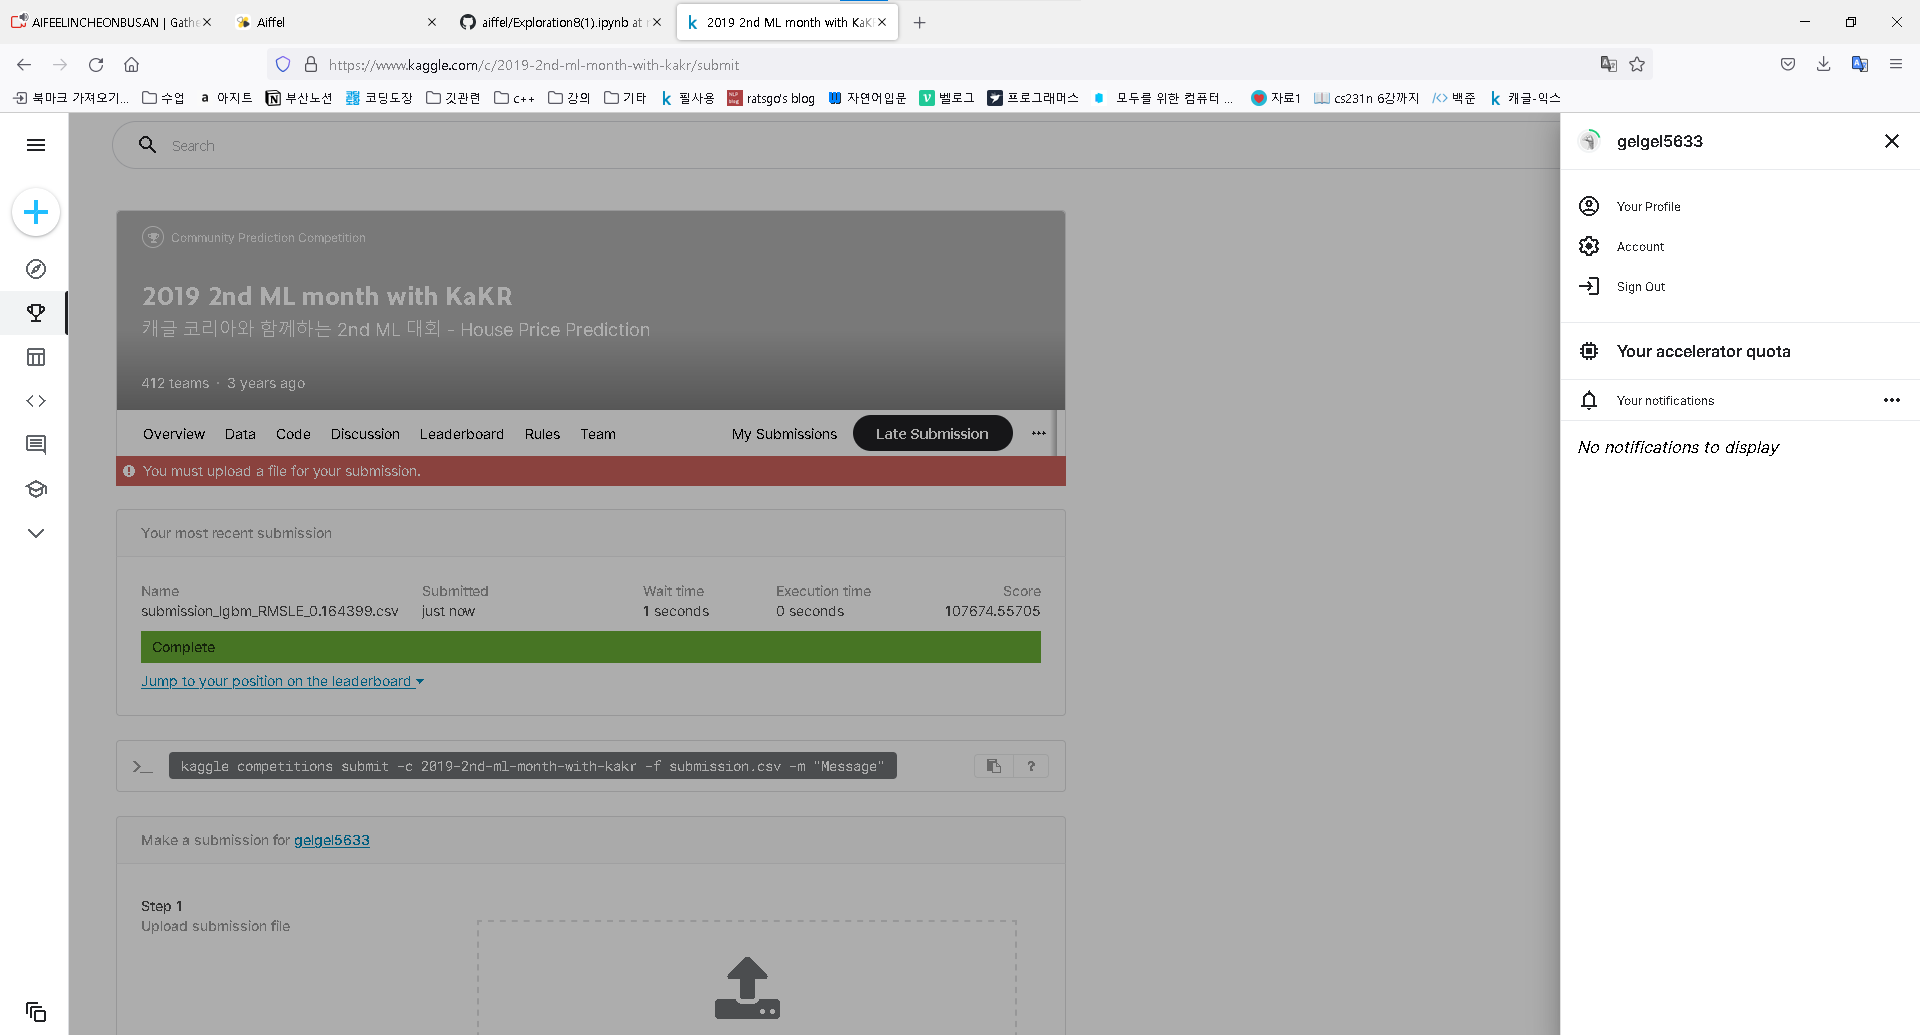

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image


img_path = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data/kaggle_submit_score.png'
im=Image.open(img_path)
im

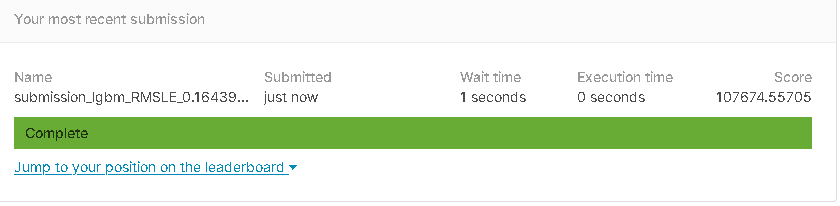

In [3]:
import os
img_path2 = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data/kaggle_submit_score2.png'
im=Image.open(img_path2)
im